# Setting up the environment, libs, loaders and etc.

In [1]:
import torch
import torchvision

!python -V; printf '\n'
!nvcc -V; printf '\n'
print(f'CUDA is available: {torch.cuda.is_available()}')
print(f'Current device: {torch.cuda.current_device()}')
print(f'Device name: {torch.cuda.get_device_name(0)}')
print(f'CUDNN version: {torch.backends.cudnn.version()}')
print(f'CUDNN enabled: {torch.backends.cudnn.enabled}')
print(f'CUDA version by torch: {torch.version.cuda}')
print(f'Torchvision version: {torchvision.__version__}')
print(f'Torchvision loc: {torchvision.__file__}')

Python 3.11.11

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0

CUDA is available: True
Current device: 0
Device name: Tesla T4
CUDNN version: 90300
CUDNN enabled: True
CUDA version by torch: 12.4
Torchvision version: 0.20.1+cu124
Torchvision loc: /usr/local/lib/python3.11/dist-packages/torchvision/__init__.py


In [28]:
import torchvision.models

model = torchvision.models.vit_b_16(pretrained=True)

num_classes = 100
model.heads.head = torch.nn.Linear(model.heads.head.in_features, num_classes)
model = nn.DataParallel(model)

In [29]:
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd
import os
from torch.utils.data import random_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

class SportsDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.label_to_idx = {label: idx for idx, label in enumerate(self.annotations['label'].unique())}

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[idx, 0])
        image = Image.open(img_path).convert("RGB")
        label_str = self.annotations.iloc[idx, 1]
        label = self.label_to_idx[label_str]
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dir = '/kaggle/input/sports-classification/train'
val_dir = '/kaggle/input/sports-classification/valid'
test_dir = '/kaggle/input/sports-classification/test'

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

print(f'Train set: {len(train_dataset)}')
print(f'Val set: {len(val_dataset)}')
print(f'Test set: {len(test_dataset)}')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

Train set: 13492
Val set: 500
Test set: 500


# ViT

In [30]:
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-5)

In [31]:
import time
from tqdm import tqdm

history = {
    'train_loss': [],
    'train_acc1': [],
    'train_acc5': [],
    'val_loss': [],
    'val_acc1': [],
    'val_acc5': []
}

def evaluate(model, dataloader, device):
    model.eval()
    correct_top1 = 0
    correct_top5 = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Validating", leave=False):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, preds = outputs.topk(5, dim=1)
            correct = preds.eq(labels.view(-1, 1))

            correct_top1 += correct[:, 0].sum().item()
            correct_top5 += correct.any(dim=1).sum().item()
            total += labels.size(0)

    avg_loss = running_loss / len(dataloader)
    acc1 = correct_top1 / total
    acc5 = correct_top5 / total

    return avg_loss, acc1, acc5

num_epochs = 20

In [32]:
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
from IPython.display import display as ipy_display
import ipywidgets as widgets

# plot_output = widgets.Output()
# ipy_display(plot_output)

def plot_history(history, plot_output, color):
    with plot_output:
        clear_output(wait=True)
        epochs = range(1, len(history['train_loss']) + 1)

        plt.figure(figsize=(18, 5))

        # 1. Loss
        plt.subplot(1, 3, 1)
        plt.plot(epochs, history['train_loss'], label='Train Loss', linestyle = '-.', color = color)
        plt.plot(epochs, history['val_loss'], label='Val Loss', linestyle = '-', color = color)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Train vs Val Loss')
        plt.legend()

        # 2. ACC@1
        plt.subplot(1, 3, 2)
        plt.plot(epochs, history['train_acc1'], label='Train ACC@1', linestyle = '-.', color = color)
        plt.plot(epochs, history['val_acc1'], label='Val ACC@1', linestyle = '-', color = color)
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Train vs Val ACC@1')
        plt.legend()

        # 3. ACC@5
        plt.subplot(1, 3, 3)
        plt.plot(epochs, history['train_acc5'], label='Train ACC@5', linestyle = '-.', color = color)
        plt.plot(epochs, history['val_acc5'], label='Val ACC@5', linestyle = '-', color = color)
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Train vs Val ACC@5')
        plt.legend()

        plt.tight_layout()
        plt.show()

### Training ViT

In [33]:
plot_output_vit = widgets.Output()
ipy_display(plot_output_vit)

# Early stopping and checkpointing settings
best_val_acc1 = 0.0
patience = 3
patience_counter = 0
save_path = '/kaggle/working/best_ViT.pth'

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_top1 = 0
    correct_top5 = 0
    total = 0

    start_time = time.time()

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, preds = outputs.topk(5, dim=1)
        correct = preds.eq(labels.view(-1, 1))

        correct_top1 += correct[:, 0].sum().item()
        correct_top5 += correct.any(dim=1).sum().item()
        total += labels.size(0)

        acc1_batch = correct[:, 0].sum().item() / labels.size(0)
        acc5_batch = correct.any(dim=1).sum().item() / labels.size(0)
        progress_bar.set_postfix(loss=loss.item(), acc1=acc1_batch, acc5=acc5_batch)

    train_time = time.time() - start_time
    train_loss = running_loss / len(train_loader)
    train_acc1 = correct_top1 / total
    train_acc5 = correct_top5 / total

    # Run validation
    val_loss, val_acc1, val_acc5 = evaluate(model, val_loader, device)

    # Store in history
    history['train_loss'].append(train_loss)
    history['train_acc1'].append(train_acc1)
    history['train_acc5'].append(train_acc5)
    history['val_loss'].append(val_loss)
    history['val_acc1'].append(val_acc1)
    history['val_acc5'].append(val_acc5)

    print(f"Epoch {epoch+1}/{num_epochs} | Time: {train_time:.1f}s")
    print(f"  Train     | Loss: {train_loss:.4f} | ACC@1: {train_acc1:.4f} | ACC@5: {train_acc5:.4f}")
    print(f"  Validation| Loss: {val_loss:.4f}   | ACC@1: {val_acc1:.4f}   | ACC@5: {val_acc5:.4f}")
    plot_history(history, plot_output_vit, color = 'blue')

    # Checkpointing and early stopping
    if val_acc1 > best_val_acc1:
        best_val_acc1 = val_acc1
        patience_counter = 0
        torch.save(model.state_dict(), save_path)
        print(f"Saved new best model (ACC@1 = {val_acc1:.4f})")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{patience}")
    if patience_counter >= patience:
        print("Early stopping triggered for ViT")
        break

Output()

Epoch 1/20 | Time: 274.5s
  Train     | Loss: 1.5966 | ACC@1: 0.7464 | ACC@5: 0.8943
  Validation| Loss: 0.3921   | ACC@1: 0.9520   | ACC@5: 0.9960


Saved new best model (ACC@1 = 0.9520)


Epoch 2/20 | Time: 274.1s
  Train     | Loss: 0.2184 | ACC@1: 0.9743 | ACC@5: 0.9984
  Validation| Loss: 0.2250   | ACC@1: 0.9580   | ACC@5: 0.9960


Saved new best model (ACC@1 = 0.9580)


Epoch 3/20 | Time: 274.0s
  Train     | Loss: 0.0582 | ACC@1: 0.9963 | ACC@5: 0.9999
  Validation| Loss: 0.1676   | ACC@1: 0.9640   | ACC@5: 1.0000


Saved new best model (ACC@1 = 0.9640)


Epoch 4/20 | Time: 273.8s
  Train     | Loss: 0.0238 | ACC@1: 0.9990 | ACC@5: 1.0000
  Validation| Loss: 0.0786   | ACC@1: 0.9820   | ACC@5: 1.0000


Saved new best model (ACC@1 = 0.9820)


Epoch 5/20 | Time: 274.0s
  Train     | Loss: 0.0250 | ACC@1: 0.9968 | ACC@5: 0.9999
  Validation| Loss: 0.1547   | ACC@1: 0.9560   | ACC@5: 1.0000


No improvement. Patience: 1/3


Epoch 6/20 | Time: 273.9s
  Train     | Loss: 0.0314 | ACC@1: 0.9956 | ACC@5: 1.0000
  Validation| Loss: 0.1321   | ACC@1: 0.9720   | ACC@5: 0.9980
No improvement. Patience: 2/3


Epoch 7/20 | Time: 274.2s
  Train     | Loss: 0.0183 | ACC@1: 0.9979 | ACC@5: 0.9997
  Validation| Loss: 0.1065   | ACC@1: 0.9700   | ACC@5: 1.0000
No improvement. Patience: 3/3
Early stopping triggered for ViT


### Saving metrics for ViT

In [34]:
import json

with open('/kaggle/working/history.json', 'w') as f:
    json.dump(history, f)

In [35]:
import gc

del model
del optimizer
torch.cuda.empty_cache()
gc.collect()

10259

# ConvNeXt

In [39]:
model_v2 = torchvision.models.convnext_base(weights=torchvision.models.ConvNeXt_Base_Weights.DEFAULT)
model_v2.classifier[2] = nn.Linear(model_v2.classifier[2].in_features, num_classes)
model_v2 = nn.DataParallel(model_v2)
model_v2 = model_v2.to(device)

In [40]:
criterion_v2 = nn.CrossEntropyLoss()
optimizer_v2 = optim.Adam(model_v2.parameters(), lr=1e-4)

history_v2 = {
    'train_loss': [],
    'train_acc1': [],
    'train_acc5': [],
    'val_loss': [],
    'val_acc1': [],
    'val_acc5': []
}

num_epochs_v2 = 20

### Training ConvNeXt

In [41]:
plot_output_convnext = widgets.Output()
ipy_display(plot_output_convnext)

# Early stopping and checkpointing settings
best_val_acc1_v2 = 0.0
patience_v2 = 3
patience_counter_v2 = 0
save_path_v2 = '/kaggle/working/best_ConvNeXt.pth'

for epoch in range(num_epochs_v2):
    # Training
    model_v2.train()
    
    running_loss = 0.0
    correct_top1 = 0
    correct_top5 = 0
    total = 0

    start_time = time.time()
    
    progress_bar_v2 = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs_v2}", leave=False)
    
    for images, labels in progress_bar_v2:
        images, labels = images.to(device), labels.to(device)
        
        optimizer_v2.zero_grad()
        outputs = model_v2(images)
        loss = criterion_v2(outputs, labels)
        loss.backward()
        optimizer_v2.step()
        
        running_loss += loss.item()
        _, preds = outputs.topk(5, dim=1)
        correct = preds.eq(labels.view(-1, 1))

        correct_top1 += correct[:, 0].sum().item()
        correct_top5 += correct.any(dim=1).sum().item()
        total += labels.size(0)

        acc1_batch = correct[:, 0].sum().item() / labels.size(0)
        acc5_batch = correct.any(dim=1).sum().item() / labels.size(0)
        progress_bar_v2.set_postfix(loss=loss.item(), acc1=acc1_batch, acc5=acc5_batch)

    train_time = time.time() - start_time
    train_loss_v2 = running_loss / len(train_loader)
    train_acc1_v2 = correct_top1 / total
    train_acc5_v2 = correct_top5 / total

    # Validation
    val_loss_v2, val_acc1_v2, val_acc5_v2 = evaluate(model_v2, val_loader, device)

    # History update
    history_v2['train_loss'].append(train_loss_v2)
    history_v2['train_acc1'].append(train_acc1_v2)
    history_v2['train_acc5'].append(train_acc5_v2)
    history_v2['val_loss'].append(val_loss_v2)
    history_v2['val_acc1'].append(val_acc1_v2)
    history_v2['val_acc5'].append(val_acc5_v2)

    # Logging
    print(f"Epoch {epoch+1}/{num_epochs_v2} | Time: {train_time:.1f}s")
    print(f"  Train     | Loss: {train_loss_v2:.4f} | ACC@1: {train_acc1_v2:.4f} | ACC@5: {train_acc5_v2:.4f}")
    print(f"  Validation| Loss: {val_loss_v2:.4f}   | ACC@1: {val_acc1_v2:.4f}   | ACC@5: {val_acc5_v2:.4f}")
    plot_history(history_v2, plot_output_convnext, color = 'orange')

    # Checkpointing and early stopping
    if val_acc1_v2 > best_val_acc1_v2:
        best_val_acc1_v2 = val_acc1_v2
        patience_counter_v2 = 0
        torch.save(model_v2.state_dict(), save_path_v2)
        print(f"Saved new best model (ACC@1 = {val_acc1_v2:.4f})")
    else:
        patience_counter_v2 += 1
        print(f"No improvement. Patience: {patience_counter_v2}/{patience_v2}")
    if patience_counter_v2 >= patience_v2:
        print("Early stopping triggered for ConvNeXt")
        break

Output()

Epoch 1/20 | Time: 330.7s
  Train     | Loss: 1.5943 | ACC@1: 0.7705 | ACC@5: 0.9059
  Validation| Loss: 0.1648   | ACC@1: 0.9800   | ACC@5: 1.0000


Saved new best model (ACC@1 = 0.9800)


Epoch 2/20 | Time: 331.2s
  Train     | Loss: 0.1518 | ACC@1: 0.9791 | ACC@5: 0.9988
  Validation| Loss: 0.0636   | ACC@1: 0.9840   | ACC@5: 1.0000


Saved new best model (ACC@1 = 0.9840)


Epoch 3/20 | Time: 330.6s
  Train     | Loss: 0.0484 | ACC@1: 0.9946 | ACC@5: 0.9999
  Validation| Loss: 0.0384   | ACC@1: 0.9880   | ACC@5: 1.0000


Saved new best model (ACC@1 = 0.9880)


Epoch 4/20 | Time: 330.4s
  Train     | Loss: 0.0251 | ACC@1: 0.9973 | ACC@5: 1.0000
  Validation| Loss: 0.0183   | ACC@1: 0.9980   | ACC@5: 1.0000


Saved new best model (ACC@1 = 0.9980)


Epoch 5/20 | Time: 330.5s
  Train     | Loss: 0.0240 | ACC@1: 0.9957 | ACC@5: 1.0000
  Validation| Loss: 0.0409   | ACC@1: 0.9880   | ACC@5: 0.9980


No improvement. Patience: 1/3


Epoch 6/20 | Time: 330.6s
  Train     | Loss: 0.0262 | ACC@1: 0.9956 | ACC@5: 0.9999
  Validation| Loss: 0.0922   | ACC@1: 0.9800   | ACC@5: 1.0000


No improvement. Patience: 2/3


Epoch 7/20 | Time: 331.3s
  Train     | Loss: 0.0285 | ACC@1: 0.9930 | ACC@5: 0.9999
  Validation| Loss: 0.0698   | ACC@1: 0.9840   | ACC@5: 1.0000


No improvement. Patience: 3/3
Early stopping triggered for ConvNeXt


### Saving metrics for ConvNeXt

In [42]:
with open('/kaggle/working/history_v2.json', 'w') as f:
    json.dump(history_v2, f)

# Losses, ACC@1 and ACC@5 during train & val for ViT and ConvNeXt

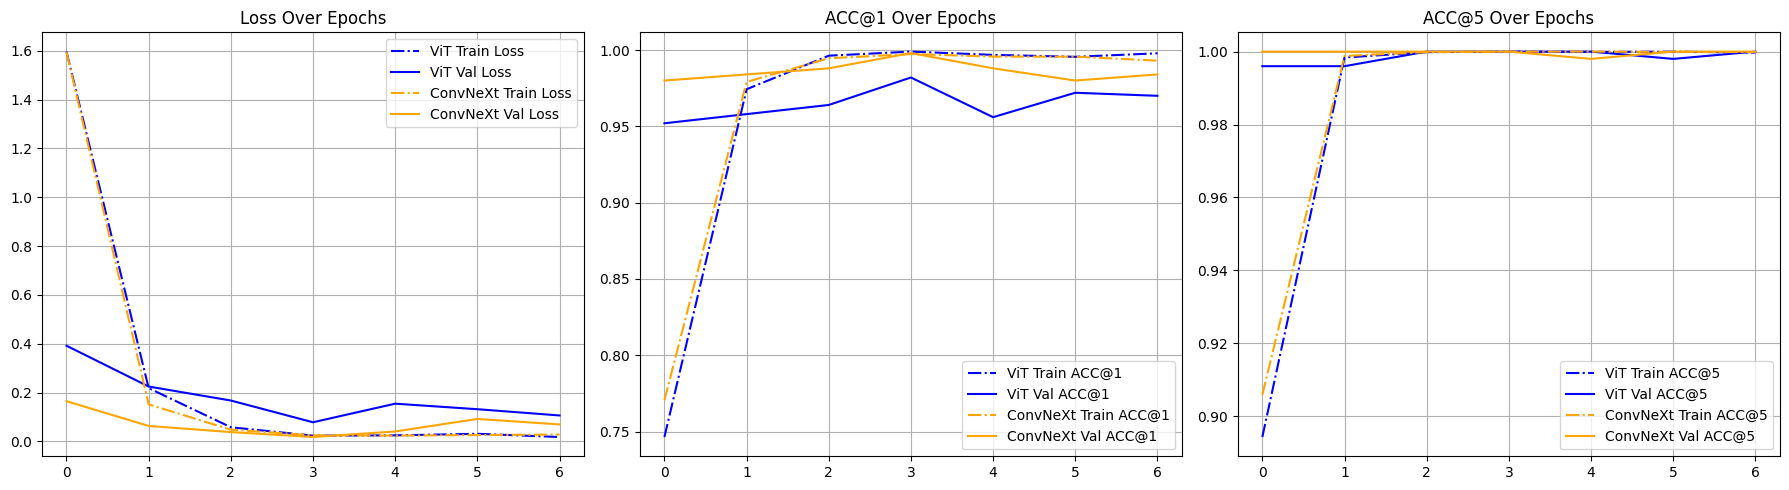

In [43]:
# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# 1. Loss
axs[0].plot(history['train_loss'], label='ViT Train Loss', color='blue', linestyle='-.')
axs[0].plot(history['val_loss'], label='ViT Val Loss', color='blue', linestyle='-')
axs[0].plot(history_v2['train_loss'], label='ConvNeXt Train Loss', color='orange', linestyle='-.')
axs[0].plot(history_v2['val_loss'], label='ConvNeXt Val Loss', color='orange', linestyle='-')
axs[0].set_title('Loss Over Epochs')
axs[0].legend()
axs[0].grid(True)

# 2. ACC@1
axs[1].plot(history['train_acc1'], label='ViT Train ACC@1', color='blue', linestyle='-.')
axs[1].plot(history['val_acc1'], label='ViT Val ACC@1', color='blue', linestyle='-')
axs[1].plot(history_v2['train_acc1'], label='ConvNeXt Train ACC@1', color='orange', linestyle='-.')
axs[1].plot(history_v2['val_acc1'], label='ConvNeXt Val ACC@1', color='orange', linestyle='-')
axs[1].set_title('ACC@1 Over Epochs')
axs[1].legend()
axs[1].grid(True)

# 3. ACC@5
axs[2].plot(history['train_acc5'], label='ViT Train ACC@5', color='blue', linestyle='-.')
axs[2].plot(history['val_acc5'], label='ViT Val ACC@5', color='blue', linestyle='-')
axs[2].plot(history_v2['train_acc5'], label='ConvNeXt Train ACC@5', color='orange', linestyle='-.')
axs[2].plot(history_v2['val_acc5'], label='ConvNeXt Val ACC@5', color='orange', linestyle='-')
axs[2].set_title('ACC@5 Over Epochs')
axs[2].legend()
axs[2].grid(True)

# Final formatting and save
plt.tight_layout()
plt.savefig('/kaggle/working/vit_vs_convnext_metrics.png')
plt.show()


### As expected, ViT does not perform very well on a small dataset. Its loss metrics and ACC are lower, it converged and started to overfit earlier than ConvNeXt although its LR is lower

### ConvNeXt seems to be better for fine-tuning on smaller dataset. Yet, its training is slower: 330 sec (compared to 274 sec on ViT)